<a href="https://colab.research.google.com/github/jarekwan/jarwan_projekt/blob/main/Projekt2A_brudnopis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 1. Pobranie i przygotowanie danych

In [11]:

#PODGLAD DANYCH ABY ZOBACZYC CO JEST W SRODKU
#TESTOWANIE

import requests
import json

# Adres API
url = "https://api.nbp.pl/api/exchangerates/tables/A?format=json"
response = requests.get(url)
data = response.json()

# Ładne formatowanie JSON (żeby było czytelnie)
#print(json.dumps(data, indent=4, ensure_ascii=False))
# widac tutaj klucze glowne: table, no, effectiveDate, rates
#pod kluczem rates sa klucze:currency, code, mid gdzi ewidac potem string i string i float

In [2]:
#TESTOWAIE
#CHCE ZOBACZYC CO JEST W POZCZEGOLNYCH WYWOLANIACH

print(data)            # całość
print(data[0])         # pierwszy słownik
print(data[0].keys())  # klucze główne
print(data[0]["rates"][0])  # pierwsza waluta
print(data[0]["rates"][0].keys())  # klucze waluty


[{'table': 'A', 'no': '187/A/NBP/2025', 'effectiveDate': '2025-09-26', 'rates': [{'currency': 'bat (Tajlandia)', 'code': 'THB', 'mid': 0.1134}, {'currency': 'dolar amerykański', 'code': 'USD', 'mid': 3.6528}, {'currency': 'dolar australijski', 'code': 'AUD', 'mid': 2.386}, {'currency': 'dolar Hongkongu', 'code': 'HKD', 'mid': 0.4695}, {'currency': 'dolar kanadyjski', 'code': 'CAD', 'mid': 2.6193}, {'currency': 'dolar nowozelandzki', 'code': 'NZD', 'mid': 2.1057}, {'currency': 'dolar singapurski', 'code': 'SGD', 'mid': 2.8264}, {'currency': 'euro', 'code': 'EUR', 'mid': 4.2668}, {'currency': 'forint (Węgry)', 'code': 'HUF', 'mid': 0.010902}, {'currency': 'frank szwajcarski', 'code': 'CHF', 'mid': 4.5705}, {'currency': 'funt szterling', 'code': 'GBP', 'mid': 4.8819}, {'currency': 'hrywna (Ukraina)', 'code': 'UAH', 'mid': 0.088}, {'currency': 'jen (Japonia)', 'code': 'JPY', 'mid': 0.024392}, {'currency': 'korona czeska', 'code': 'CZK', 'mid': 0.1756}, {'currency': 'korona duńska', 'code':

🔹 Etapy projektu
1. Pobranie i przygotowanie danych
•	Pobranie danych z API (np. NBP, Eurostat)
•	Serializacja → zapis do JSON/CSV.
•	Walidacja struktur (Pydantic + regex dla kolumn typu daty/kody walut).
•	Wstępne czyszczenie braków i wartości odstających.


In [5]:
# poprawiana wersja
#WLASCIWY KOD
#POBRANIE ,SERIALIZACJA
import pandas as pd
import requests

# --- Pobranie danych z API NBP ---
url = "https://api.nbp.pl/api/exchangerates/tables/A?format=json"
response = requests.get(url)

# Sprawdzenie czy żądanie się powiodło
if response.status_code != 200:
    raise Exception(f"Błąd pobierania danych z API (status {response.status_code})")

# Konwersja odpowiedzi JSON na DataFrame
data = response.json()
df = pd.json_normalize(data[0]["rates"])

# Podgląd danych
print("Podgląd danych z API NBP:")
print(df.head())
# --- Serializacja ---
df.to_csv("kursy_walut.csv", index=False)
df.to_json("kursy_walut.json", orient="records", force_ascii=False, indent=2)

print("✅ Dane zapisane do plików: kursy_walut.csv i kursy_walut.json")




Podgląd danych z API NBP:
             currency code     mid
0     bat (Tajlandia)  THB  0.1134
1   dolar amerykański  USD  3.6528
2  dolar australijski  AUD  2.3860
3     dolar Hongkongu  HKD  0.4695
4    dolar kanadyjski  CAD  2.6193
✅ Dane zapisane do plików: kursy_walut.csv i kursy_walut.json


Walidacja + Czyszczenie

In [12]:
from pydantic import BaseModel, Field, ValidationError
from typing import Annotated

# Walidacja typów
CurrencyCode = Annotated[str, Field(pattern=r"^[A-Z]{3}$")]

# Model z 3 polami: currency, code, mid
class Currency(BaseModel):
    currency: str              # nazwa waluty (np. "dolar amerykański")
    code: CurrencyCode         # kod waluty (np. "USD")
    mid: float                 # kurs waluty (np. 3.62)

# Walidacja każdego rzędu z df
try:
    for _, row in df.iterrows():
        Currency(**row)        # sprawdzamy cały rząd: 3 pola naraz
    print("✅ Wszystkie wiersze poprawne")
except ValidationError as e:
    print("❌ Błąd walidacji:", e)


    # Sprawdzenie braków danych
print("\nBraki danych:")
print(df.isna().sum())

# Wstępne sprawdzenie odstających wartości
print("\nStatystyki opisowe dla kolumny 'mid':")
print(df["mid"].describe())

# Przykład filtrowania outlierów (np. kursy < 0.1 lub > 100)
outliers = df[(df["mid"] < 0.1) | (df["mid"] > 100)]
print(f"\nLiczba podejrzanych kursów: {len(outliers)}")
if not outliers.empty:
    print(outliers)



✅ Wszystkie wiersze poprawne

Braki danych:
currency    0
code        0
mid         0
dtype: int64

Statystyki opisowe dla kolumny 'mid':
count    33.000000
mean      1.251368
std       1.615188
min       0.000218
25%       0.087800
50%       0.469500
75%       2.181600
max       4.981500
Name: mid, dtype: float64

Liczba podejrzanych kursów: 10
                   currency code       mid
8            forint (Węgry)  HUF  0.010902
11         hrywna (Ukraina)  UAH  0.088000
12            jen (Japonia)  JPY  0.024392
15         korona islandzka  ISK  0.029963
20             lira turecka  TRY  0.087800
22          peso chilijskie  CLP  0.003810
23         peso filipińskie  PHP  0.062900
28       rupia indonezyjska  IDR  0.000218
29           rupia indyjska  INR  0.041176
30  won południowokoreański  KRW  0.002590


KONTYNUACJA :Symulacje i rozkłady (NumPy + Matplotlib)
•	generowanie próbek z rozkładu normalnego, jednorodnego, wykładniczego,
•	wizualizacja histogramów + porównanie z teoretyczną krzywą gęstości,
•	demonstracja CLT.


PONIZEJ NA BRUDNO ROBOCZA WERSJA

In [ ]:

import pandas as pd
import numpy as np
import requests
import re
from pydantic import BaseModel, ValidationError

# Przykład pobrania danych (API NBP kursy walut)
url = "https://api.nbp.pl/api/exchangerates/tables/A?format=json"
data = requests.get(url).json()
df = pd.json_normalize(data[0]['rates'])
print(df.head())

# Walidacja kolumny waluty
class Currency(BaseModel):
    code: str

try:
    for c in df['code']:
        Currency(code=c)
except ValidationError as e:
    print(e)

# Prosta serializacja
df.to_csv("data.csv", index=False)


             currency code     mid
0     bat (Tajlandia)  THB  0.1130
1   dolar amerykański  USD  3.6295
2  dolar australijski  AUD  2.3949
3     dolar Hongkongu  HKD  0.4666
4    dolar kanadyjski  CAD  2.6127


 2. EDA (eksploracja danych)

             mid
count  33.000000
mean    1.249594
std     1.612480
min     0.000217
25%     0.087300
50%     0.466600
75%     2.179100
max     4.970800


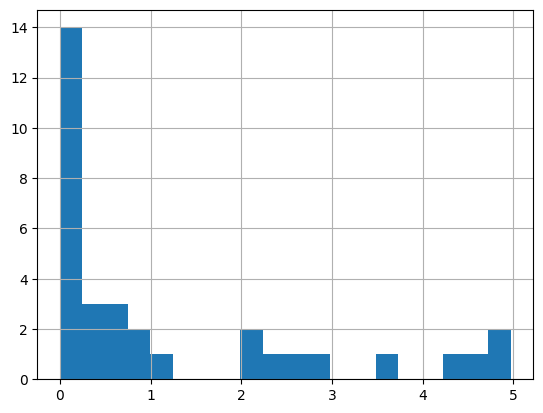

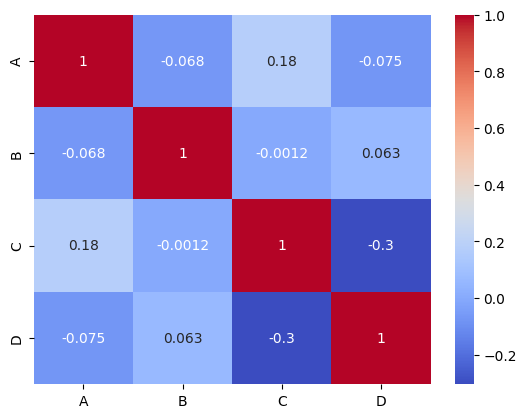

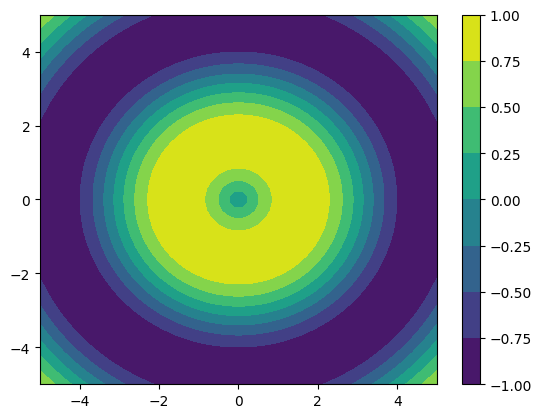

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

print(df.describe())

# Histogram
df['mid'].hist(bins=20)
plt.show()

# Heatmapa korelacji (przykład na sztucznych danych)
df2 = pd.DataFrame(np.random.randn(100, 4), columns=list("ABCD"))
sns.heatmap(df2.corr(), annot=True, cmap="coolwarm")
plt.show()

# Meshgrid + contour plot
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

plt.contourf(X, Y, Z, cmap="viridis")
plt.colorbar()
plt.show()


3. Statystyka klasyczna

95% CI: (np.float64(98.69413389083786), np.float64(103.90888880610567))
Shapiro-Wilk: ShapiroResult(statistic=np.float64(0.9774151949589392), pvalue=np.float64(0.4488425719013703))
T-test: TtestResult(statistic=np.float64(0.9783452568427398), pvalue=np.float64(0.3327093449779359), df=np.int64(49))


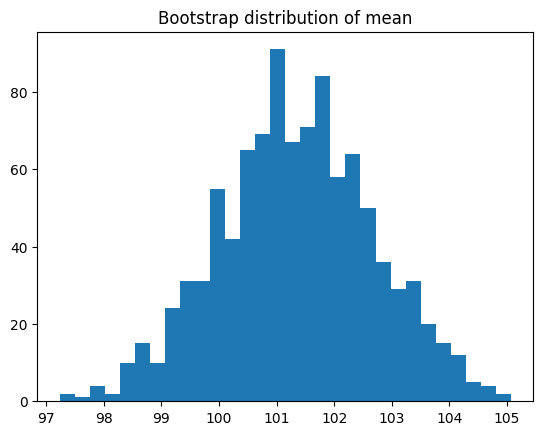

In [ ]:

from scipy import stats

# Przedział ufności dla średniej
sample = np.random.normal(loc=100, scale=10, size=50)
conf_int = stats.norm.interval(0.95, loc=np.mean(sample), scale=stats.sem(sample))
print("95% CI:", conf_int)

# Test normalności
print("Shapiro-Wilk:", stats.shapiro(sample))

# Test t
print("T-test:", stats.ttest_1samp(sample, 100))

# Bootstrap
boot_means = []
for _ in range(1000):
    boot_sample = np.random.choice(sample, size=len(sample), replace=True)
    boot_means.append(np.mean(boot_sample))
plt.hist(boot_means, bins=30)
plt.title("Bootstrap distribution of mean")
plt.show()


4. Regresja liniowa

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     990.8
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           1.05e-33
Time:                        15:57:34   Log-Likelihood:                -103.75
No. Observations:                  50   AIC:                             211.5
Df Residuals:                      48   BIC:                             215.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7493      0.548     12.315      0.0

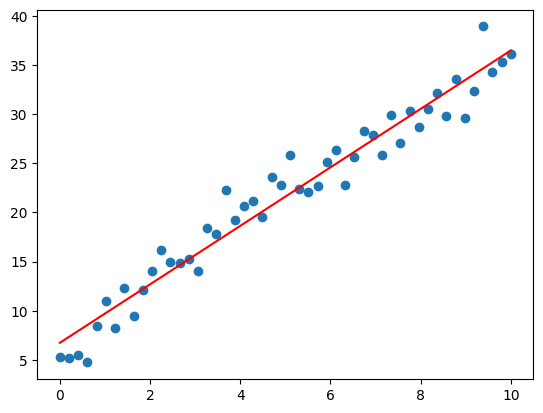

In [ ]:
# =======================================
# 4. Regresja liniowa
# =======================================
import statsmodels.api as sm

X = np.linspace(0, 10, 50)
Y = 3*X + 7 + np.random.normal(0, 2, 50)

X_ = sm.add_constant(X)
model = sm.OLS(Y, X_).fit()
print(model.summary())

plt.scatter(X, Y)
plt.plot(X, model.predict(X_), color="red")
plt.show()


5. Regularyzacja (Ridge, Lasso)

In [ ]:

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X = df2.drop("A", axis=1)
y = df2["A"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
lasso = make_pipeline(StandardScaler(), Lasso(alpha=0.1))

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

print("Ridge R2:", ridge.score(X_test, y_test))
print("Lasso R2:", lasso.score(X_test, y_test))


Ridge R2: -0.1662488415345651
Lasso R2: -0.10731336350517173


6. Szeregi czasowe

/tmp/ipython-input-3685064161.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range("2020-01-01", periods=100, freq="M")


ADF test: (np.float64(0.6266193983771053), np.float64(0.9882537006790334), 11, 88, {'1%': np.float64(-3.506944401824286), '5%': np.float64(-2.894989819214876), '10%': np.float64(-2.584614550619835)}, np.float64(568.1195638563936))
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -322.395
Date:                Thu, 25 Sep 2025   AIC                            650.791
Time:                        15:58:17   BIC                            658.576
Sample:                    01-31-2020   HQIC                           653.941
                         - 04-30-2028                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

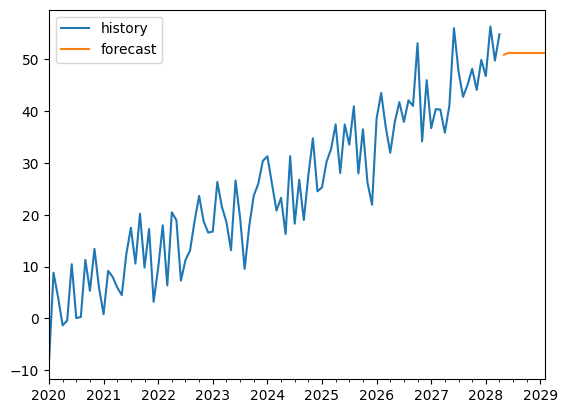

In [ ]:

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Dane sztuczne: trend + szum
dates = pd.date_range("2020-01-01", periods=100, freq="M")
ts = pd.Series(0.5*np.arange(100) + np.random.normal(0, 5, 100), index=dates)

# Test stacjonarności
print("ADF test:", adfuller(ts))

# ARIMA model
model = ARIMA(ts, order=(1,1,1)).fit()
print(model.summary())

forecast = model.forecast(10)
ts.plot(label="history")
forecast.plot(label="forecast")
plt.legend()
plt.show()


7. Prezentacja wyników

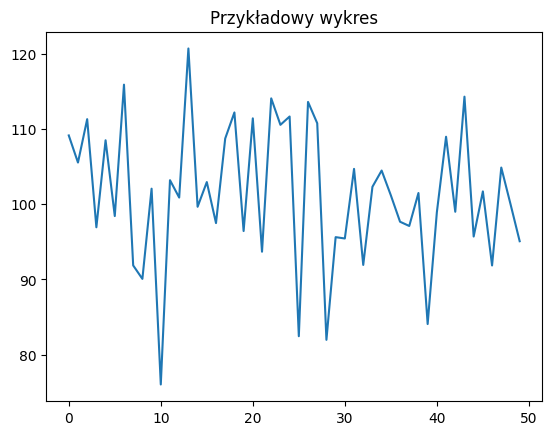

In [ ]:

# Zapis do pliku
df.describe().to_csv("report.csv")

# Przykładowy wykres PNG
plt.plot(sample)
plt.title("Przykładowy wykres")
plt.savefig("report.png")
